# Solvers for Additive-Noise SDEs
SDEs of the form
$$dX_t = f(t, X_t) \, dt + σ \, dW_t$$
are said to have additive noise, since the matrix $\sigma$ in the noise term is independent of $t$ and $X$. Such SDEs permit special solvers with a higher order of strong convergence than those for general SDEs. A few such solvers are presented below.

The high convergence rate of these solvers comes at the cost of requiring information about the Brownian motion's space-time Lévy area, defined as
$$
    H_{s,t} = \frac{1}{t-s}  \int_{s}^{t}  W_u - \frac{u - s}{t - s} W_{s,t} \; du.
$$
We modified the `VirtualBrownianTree` and the `UnsafeBrownianPath` to compute the increments of $H$ in addition to those of $W$. To enable this functionality, these objects must be initialised with `levy_area="space-time"`.


## Underdamped Langevin diffusion and `diffrax.LangevinTerm`
An example of an additive-noise SDE is the Underdamped Langevin diffusion (ULD):
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.
\end{align*}

In Diffrax ULD can be reperesented using `diffrax.LangevinTerm((gamma, u, grad_f), bm, x0)`. For more details see the cell under the "2D Harmonic Oscillator" heading.

Below we use four examples of Langevin-type SDEs to demonstrate the operation of our solvers.



# Solvers

## ALIGN
`ALIGN` has strong order 2 and is FSAL, meaning it only performs 1 evaulation of $\nabla f$ per step.
It can only be used for a Langevin SDE of the form
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \, \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.
\end{align*}
ALIGN natively supports adaptive-stepping via an embedded method for error estimation.


## SORT
Similar to ALIGN, but also uses space-time-time Levy area in order to achieve strong order 3. Also only suitable for Langevin SDEs.
Uses three evaluations of the vector-field per step, but it is FSAL, so in practice it only uses two.
At this point it can only be used adaptively if a `HalfSolver` is used.


## ShOULD
`ShOULD` takes the 3rd order convergence from `SORT` and complements it with the improved trajectory computation from `ALIGN`. It can only be used for Langevin SDEs.


## ShARK
`ShARK` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. Unlike ALIGN or SORT it can be used for any additive-noise SDE.
 It has a better local error than SRA1. Uses two evaluations of the vector-field per step.

Based on equation (6.1) in
    Foster, J., dos Reis, G., & Strange, C. (2023).
    High order splitting methods for SDEs satisfying a commutativity condition.
    arXiv [Math.NA] http://arxiv.org/abs/2210.17543
    

## SRA1
`SRA1` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. It natively supports adaptive-stepping via an embedded method for error estimation. Uses two evaluations of the vector-field per step.

Based on the SRA1 method from
    A. Rößler, Runge–Kutta methods for the strong approximation of solutions of stochastic differential equations,
    SIAM Journal on Numerical Analysis, 8 (2010), pp. 922–952.
    

## Shifted Additive-noise Euler (SEA)
This variant of the Euler-Maruyama makes use of the space-time Levy area, which improves its local error to $O(h^2)$ compared to $O(h^{1.5})$ of the standard Euler-Maruyama.

In [1]:
%env JAX_PLATFORM_NAME=cuda

from test.helpers import (
    get_bqp,
    get_harmonic_oscillator,
    get_neals_funnel,
    get_uld3_langevin,
    simple_batch_sde_solve,
)
from warnings import simplefilter

import diffrax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
from diffrax import (
    ALIGN,
    diffeqsolve,
    nUBU,  # noqa: F401
    PIDController,
    QUICSORT,
    ShARK,
    ShOULD,
    UBU,  # noqa: F401
)
from diffrax._solver.sort_uld import SORT
from drawing_and_evaluating import (
    animated_funnel_plot,
    constant_step_strong_order,  # noqa: F401
    draw_order_multiple,
    get_fine_solutions,  # noqa: F401
    load_order_results,
    load_ref_sol_langevin,
    plot_sol3D,
    plot_sol_langevin,
    remove_steps,
    save_order_results,  # noqa: F401
)
from jax import config


simplefilter("ignore", category=FutureWarning)
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_disable_jit", False)
jnp.set_printoptions(precision=4, suppress=True)

dtype = jnp.float64
key = jr.PRNGKey(2)
num_samples = 5000
keys = jr.split(jr.PRNGKey(5678), num=num_samples)
keys_funnel = jr.split(jr.PRNGKey(77), 100)

t0, t1 = 0.0, 16.0
t_short = 4.0
t_long = 32.0
dt0 = 0.1
bm_tol = 2**-16
levy_area = diffrax.SpaceTimeTimeLevyArea

half_should = diffrax.HalfSolver(ShOULD(0.01))
half_sort = diffrax.HalfSolver(SORT(0.01))
half_heun = diffrax.HalfSolver(diffrax.Heun())
half_align = diffrax.HalfSolver(ALIGN(0.1))
half_shark = diffrax.HalfSolver(ShARK())
half_sra1 = diffrax.HalfSolver(diffrax.SRA1())

env: JAX_PLATFORM_NAME=cuda


## A 2D Harmonic Oscillator
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \, \mathbf{x}_t \, dt + \sqrt{2 \gamma u} \, d W_t
\end{align*}
where $\mathbf{x}_t, \mathbf{v}_t, W_t \in \mathbb{R}^2$.

100.00%|██████████| [00:00<00:00, 258.39%/s]


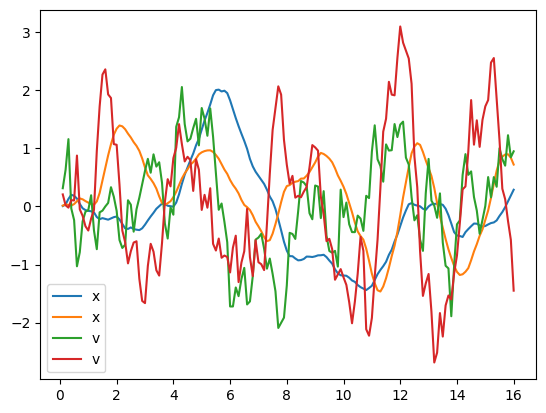

In [2]:
from test.helpers import make_underdamped_langevin_term


# Defining the SDE
gamma_hosc = jnp.array([2, 0.5], dtype=dtype)
u_hosc = jnp.array([0.5, 2], dtype=dtype)


def grad_f_hosc(x):
    return 2 * x


x0 = jnp.zeros((2,), dtype=dtype)
v0 = jnp.zeros((2,), dtype=dtype)
y0_hosc = (x0, v0)
bm = diffrax.VirtualBrownianTree(
    t0, t1, tol=2**-10, shape=(2,), key=jr.key(0), levy_area=levy_area
)

terms_hosc = make_underdamped_langevin_term(gamma_hosc, u_hosc, grad_f_hosc, bm)

solQUIC = diffeqsolve(
    terms_hosc,
    QUICSORT(0.0),
    t0,
    t1,
    dt0=dt0,
    y0=y0_hosc,
    args=None,
    saveat=diffrax.SaveAt(steps=True),
    progress_meter=diffrax.TqdmProgressMeter(),
)
plot_sol_langevin(solQUIC)

In [3]:
hosc = get_harmonic_oscillator(t0, t1, dtype=dtype)
hosc_short = get_harmonic_oscillator(t0, t_short, dtype=dtype)
# Save the finely discretised solutions for the harmonic oscillator
# ref_sol_hosc = get_fine_solutions(keys, hosc_short, ShARK(), levy_area, bm_tol, 6, 16)
# jnp.save("data/ref_sol_hosc.npy", ref_sol_hosc)
ref_sol_hosc = load_ref_sol_langevin("hosc")
print(jtu.tree_map(lambda x: x.shape, ref_sol_hosc))

((5000, 65, 2), (5000, 65, 2))


In [4]:
# out_ALIGN_hosc = constant_step_strong_order(keys, hosc_short, ALIGN(0.1), (2, 8), bm_tol, levy_area, ref_sol_hosc)
# save_order_results(out_ALIGN_hosc, "hosc_ALIGN_const")
out_ALIGN_hosc = load_order_results("hosc_ALIGN_const")

# out_ShOULD_hosc = constant_step_strong_order(
#     keys, hosc_short, ShOULD(0.01), (2, 8), bm_tol, levy_area, ref_sol_hosc
# )
# save_order_results(out_ShOULD_hosc, "hosc_ShOULD_const")
out_ShOULD_hosc = load_order_results("hosc_ShOULD_const")

# out_SORT_hosc = constant_step_strong_order(keys, hosc_short, SORT(0.01), (2, 8), bm_tol, levy_area, ref_sol_hosc)
# save_order_results(out_SORT_hosc, "hosc_SORT_const")
out_SORT_hosc = load_order_results("hosc_SORT_const")

# out_ShARK_hosc = constant_step_strong_order(keys, hosc_short, ShARK(), (2, 8), bm_tol, levy_area, ref_sol_hosc)
# save_order_results(out_ShARK_hosc, "hosc_ShARK_const")
out_ShARK_hosc = load_order_results("hosc_ShARK_const")
out_ShARK_hosc = remove_steps(out_ShARK_hosc, 1, 0)

# out_QUICSORT_hosc = constant_step_strong_order(keys, hosc_short, QUICSORT(0.01), (2, 8), bm_tol, levy_area, ref_sol_hosc)
# save_order_results(out_QUICSORT_hosc, "hosc_QUICSORT_const")
out_QUICSORT_hosc = load_order_results("hosc_QUICSORT_const")

# out_UBU_hosc = constant_step_strong_order(
#     keys, hosc_short, UBU(0.01), (2, 8), bm_tol, levy_area, ref_sol_hosc
# )
# save_order_results(out_UBU_hosc, "hosc_UBU_const")
out_UBU_hosc = load_order_results("hosc_UBU_const")

out_nUBU_hosc = constant_step_strong_order(
    keys, hosc_short, nUBU(0.1), (2, 8), bm_tol, levy_area, ref_sol_hosc
)
save_order_results(out_nUBU_hosc, "hosc_nUBU_const")
out_nUBU_hosc = load_order_results("hosc_nUBU_const")

Loaded data/order_results_hosc_ALIGN_const.npy
Loaded data/order_results_hosc_ShOULD_const.npy
Loaded data/order_results_hosc_SORT_const.npy
Loaded data/order_results_hosc_ShARK_const.npy
7
Loaded data/order_results_hosc_QUICSORT_const.npy
Loaded data/order_results_hosc_UBU_const.npy
Saved data/order_results_hosc_nUBU_const.npy
Loaded data/order_results_hosc_nUBU_const.npy


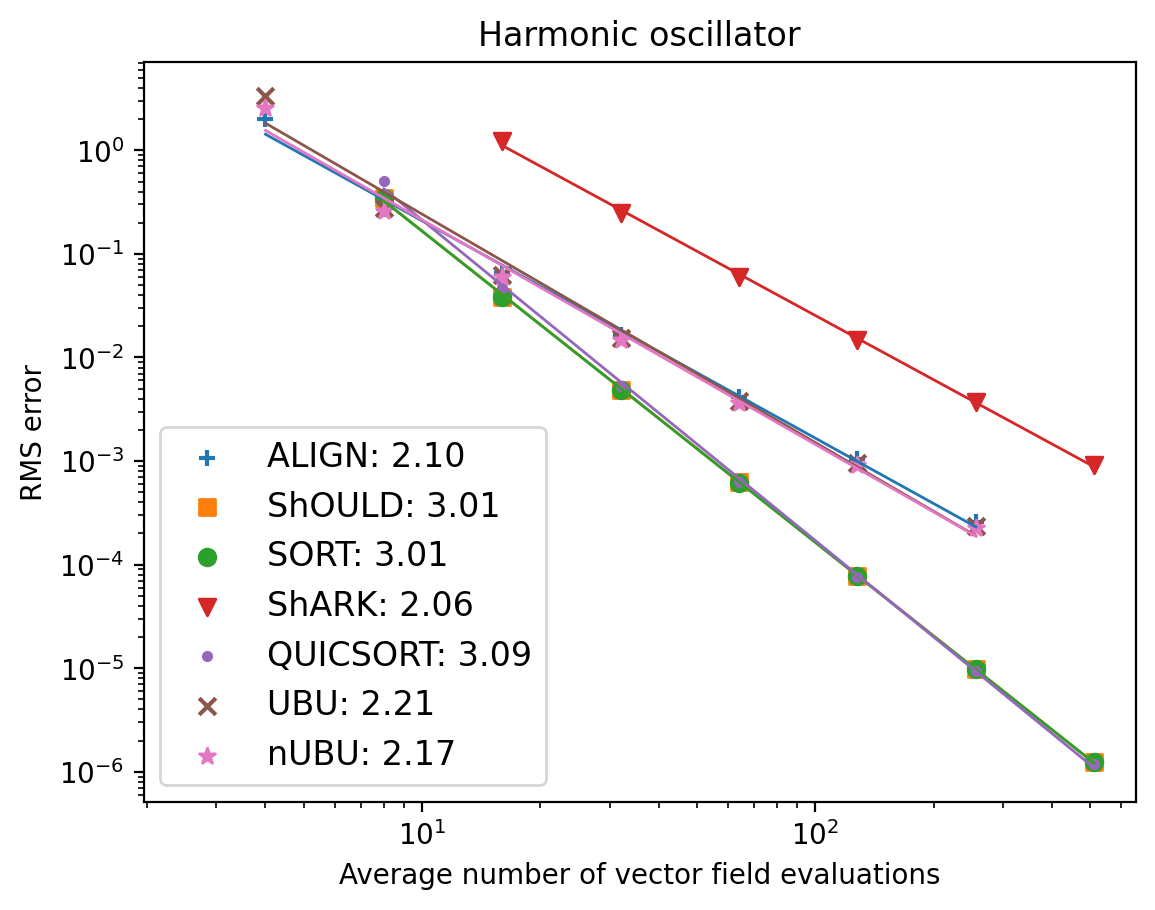

In [5]:
_ = draw_order_multiple(
    [
        out_ALIGN_hosc,
        out_ShOULD_hosc,
        out_SORT_hosc,
        out_ShARK_hosc,
        out_QUICSORT_hosc,
        out_UBU_hosc,
        out_nUBU_hosc,
    ],
    ["ALIGN", "ShOULD", "SORT", "ShARK", "QUICSORT", "UBU", "nUBU"],
    title="Harmonic oscillator",
)

# Experiments on different versions of the langevin SDE

## Neal's funnel

Neal's funnel is a 10-dimensional funnel-shaped distribution commonly used as test case for MCMC algorithms. The target distribution is given by
$$
    Z \sim \mathcal{N}(0, 3) \quad \text{and} \quad Y \sim \mathcal{N}(0, \exp(Z) \mathbf{I}_{9}).
$$
This is easy to sample from normally, but presents a challenge for MCMC methods to converge to, due to the narrow funnel shape.

We use the following Langevin SDE to sample from the funnel:
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \mathbf{v}_t \, dt - \,
    \nabla \log p \, ( \mathbf{x}_t ) \, dt + \sqrt{2} \, d W_t
\end{align*}

where $p$ is the target distribution.

In [2]:
funnel = get_neals_funnel(t0, t_long, dtype=dtype)
terms_funnel = funnel.get_terms(funnel.get_bm(key, levy_area=levy_area, tol=2**-12))

# ref_sol_funnel = get_fine_solutions(keys_funnel, funnel, SORT(0.01), levy_area, bm_tol, 6, 15)
# jnp.save("data/ref_sol_funnel.npy", ref_sol_funnel)
ref_sol_funnel = load_ref_sol_langevin("funnel")

In [3]:
# out_SORT_funnel_pid = pid_strong_order(
#     keys_funnel,
#     funnel,
#     half_sort,
#     (4, 20),
#     bm_tol,
#     levy_area,
#     ref_sol_funnel,
# )
# save_order_results(out_SORT_funnel_pid, "funnel_SORT_pid")
out_SORT_funnel_pid = load_order_results("funnel_SORT_pid")

# out_SORT_funnel_const = constant_step_strong_order(
#     keys_funnel, funnel, SORT(0.01), (6, 12), bm_tol, levy_area, ref_sol_funnel
# )
# save_order_results(out_SORT_funnel_const, "funnel_SORT_const")
out_SORT_funnel_const = load_order_results("funnel_SORT_const")

# out_SRA1_funnel_pid = pid_strong_order(keys_funnel, funnel, half_sra1, (1, 11), bm_tol, levy_area, ref_sol_funnel)
# save_order_results(out_SRA1_funnel_pid, "funnel_SRA1_pid")
out_SRA1_funnel_pid = load_order_results("funnel_SRA1_pid")

# out_Euler_funnel_const = constant_step_strong_order(
#     keys_funnel, funnel, diffrax.Euler(), (6, 13), bm_tol, levy_area, ref_sol_funnel
# )
# save_order_results(out_Euler_funnel_const, "funnel_Euler_const")
out_Euler_funnel_const = load_order_results("funnel_Euler_const")

# out_QUICSORT_funnel_const = constant_step_strong_order(
#     keys_funnel, funnel, QUICSORT(0.01), (6, 12), bm_tol, levy_area, ref_sol_funnel
# )
# save_order_results(out_QUICSORT_funnel_const, "funnel_QUICSORT_const")
out_QUICSORT_funnel_const = load_order_results("funnel_QUICSORT_const")

Loaded data/order_results_funnel_SORT_pid.npy
Loaded data/order_results_funnel_SORT_const.npy
Loaded data/order_results_funnel_SRA1_pid.npy
Loaded data/order_results_funnel_Euler_const.npy
Loaded data/order_results_funnel_UBU3_const.npy


In [4]:
out_SORT_funnel_pid = remove_steps(out_SORT_funnel_pid, 6, 0)
out_SORT_funnel_const = remove_steps(out_SORT_funnel_const, 0, 1)
out_QUICSORT_funnel_const = remove_steps(out_QUICSORT_funnel_const, 0, 1)

17
7
7


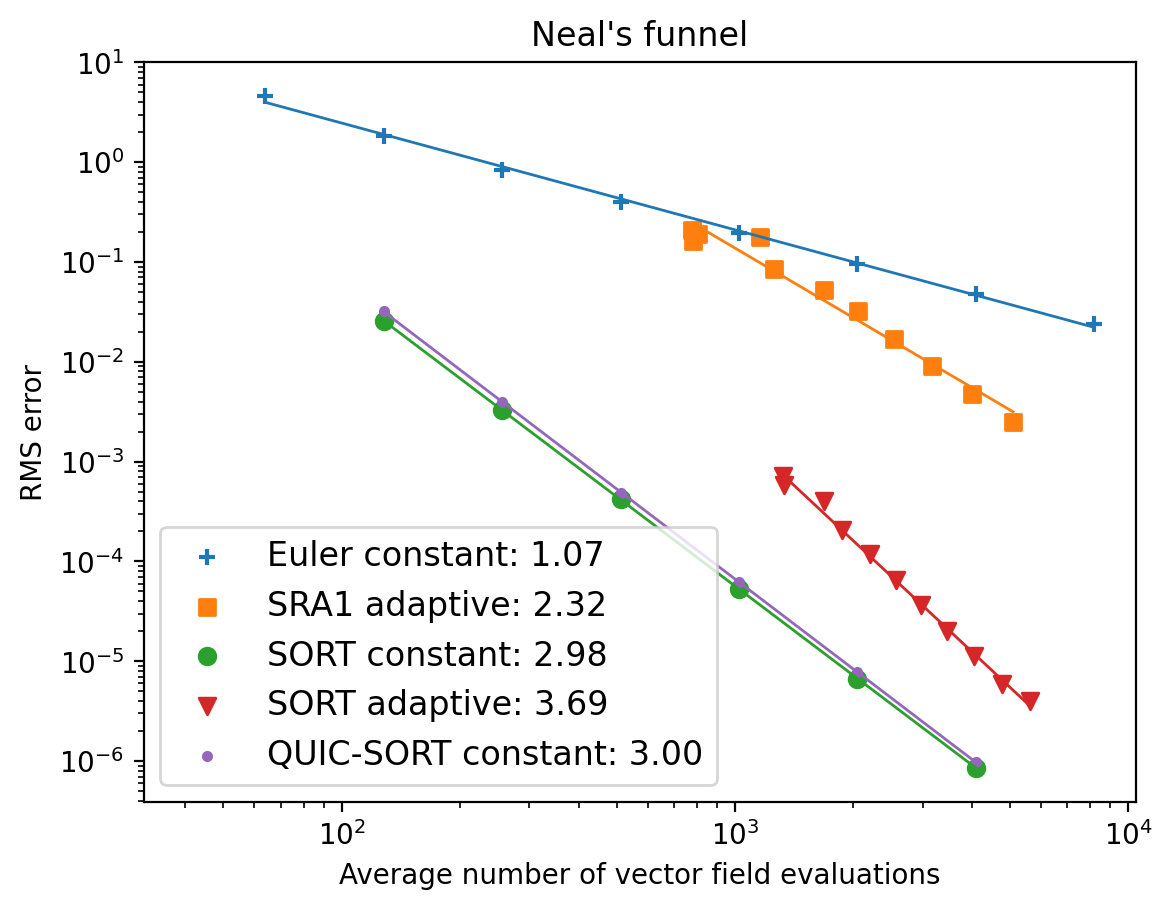

In [7]:
fig = draw_order_multiple(
    [
        out_Euler_funnel_const,
        out_SRA1_funnel_pid,
        out_SORT_funnel_const,
        out_SORT_funnel_pid,
        out_QUICSORT_funnel_const,
    ],
    [
        "Euler constant",
        "SRA1 adaptive",
        "SORT constant",
        "SORT adaptive",
        "QUIC-SORT constant",
    ],
    title="Neal's funnel",
)
# fig.savefig("graphs/funnel_convergence.png")
# fig.savefig("graphs/funnel_convergence.pdf")

Make an animation of the funnel sampling process

In [21]:
funnel_save_steps = jnp.linspace(t0, t_long, 2**9 + 1, endpoint=True)
pid_contr = PIDController(
    pcoeff=0.1,
    icoeff=0.3,
    rtol=0,
    atol=2**-10,
    dtmin=2**-14,
)
contr = diffrax.JumpStepWrapper(
    pid_contr,
    step_ts=funnel_save_steps,
)

batch_solSORTfunnel = simple_batch_sde_solve(
    keys_funnel,
    funnel,
    half_sort,
    levy_area,
    None,
    controller=contr,
    bm_tol=2**-16,
    saveat=diffrax.SaveAt(ts=funnel_save_steps),
)
ysSORTfunnel = batch_solSORTfunnel.ys
ani, fig, ax = animated_funnel_plot(batch_solSORTfunnel)
ani.save("funnel.gif", writer="pillow")

## Particle in a Bistable Quartic Potential
\begin{align*}
    d x_t &= v_t \, dt \\
    d v_t &= - \gamma \, v_t \, dt - u \, \nabla \! f( x_t ) \, dt + \sqrt{2 \gamma u} \, d W_t
\end{align*}
where $x_t, v_t, W_t \in \mathbb{R}$ and $f(x) = (x-1)^2 (x+1)^2$.

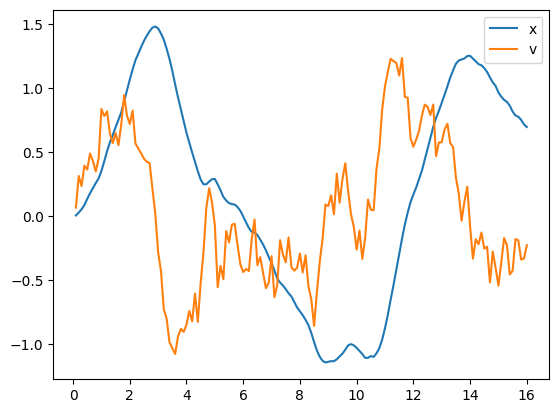

In [6]:
bqp = get_bqp(t0, t1, dtype=dtype)
terms_bqp = bqp.get_terms(bqp.get_bm(key, levy_area=levy_area, tol=2**-10))
bqp_short = get_bqp(t0, t_short, dtype=dtype)

solALIGN_bqp = diffeqsolve(
    terms_bqp,
    ALIGN(0.1),
    t0,
    t1,
    dt0=dt0,
    y0=bqp.y0,
    args=bqp.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_langevin(solALIGN_bqp)

In [7]:
# ref_sol_bqp = get_fine_solutions(keys, bqp_short, ShARK(), levy_area, bm_tol, 6, 16)
# jnp.save("data/ref_sol_bqp.npy", ref_sol_bqp)
ref_sol_bqp = load_ref_sol_langevin("bqp")
print(jtu.tree_map(lambda x: x.shape, ref_sol_bqp))

((5000, 65), (5000, 65))


In [8]:
# out_ALIGN_bqp = constant_step_strong_order(keys, bqp_short, ALIGN(0.1), (2,8), bm_tol, levy_area, ref_sol_bqp)
# save_order_results(out_ALIGN_bqp, "bqp_ALIGN_const")
out_ALIGN_bqp = load_order_results("bqp_ALIGN_const")

# out_ShOULD_bqp = constant_step_strong_order(
#     keys, bqp_short, ShOULD(0.01), (2,8), bm_tol, levy_area, ref_sol_bqp
# )
# save_order_results(out_ShOULD_bqp, "bqp_ShOULD_const")
out_ShOULD_bqp = load_order_results("bqp_ShOULD_const")

# out_SORT_bqp = constant_step_strong_order(keys, bqp_short, SORT(0.01), (2,8), bm_tol, levy_area, ref_sol_bqp)
# save_order_results(out_SORT_bqp, "bqp_SORT_const")
out_SORT_bqp = load_order_results("bqp_SORT_const")

# out_ShARK_bqp = constant_step_strong_order(keys, bqp_short, ShARK(), (2,8), bm_tol, levy_area, ref_sol_bqp)
# save_order_results(out_ShARK_bqp, "bqp_ShARK_const")
out_ShARK_bqp = load_order_results("bqp_ShARK_const")

# out_QUICSORT_bqp = constant_step_strong_order(keys, bqp_short, QUICSORT(0.01), (2,8), bm_tol, levy_area, ref_sol_bqp)
# save_order_results(out_QUICSORT_bqp, "bqp_QUICSORT_const")
out_QUICSORT_bqp = load_order_results("bqp_QUICSORT_const")

# out_UBU_bqp = constant_step_strong_order(keys, bqp_short, UBU(0.01), (2,8), bm_tol, levy_area, ref_sol_bqp)
# save_order_results(out_UBU_bqp, "bqp_UBU_const")
out_UBU_bqp = load_order_results("bqp_UBU_const")

out_nUBU_bqp = constant_step_strong_order(
    keys, bqp_short, nUBU(0.01), (2, 8), bm_tol, levy_area, ref_sol_bqp
)
save_order_results(out_nUBU_bqp, "bqp_nUBU_const")
out_nUBU_bqp = load_order_results("bqp_nUBU_const")

Loaded data/order_results_bqp_ALIGN_const.npy
Loaded data/order_results_bqp_ShOULD_const.npy
Loaded data/order_results_bqp_SORT_const.npy
Loaded data/order_results_bqp_ShARK_const.npy
Loaded data/order_results_bqp_QUICSORT_const.npy
Loaded data/order_results_bqp_UBU_const.npy
Saved data/order_results_bqp_nUBU_const.npy
Loaded data/order_results_bqp_nUBU_const.npy


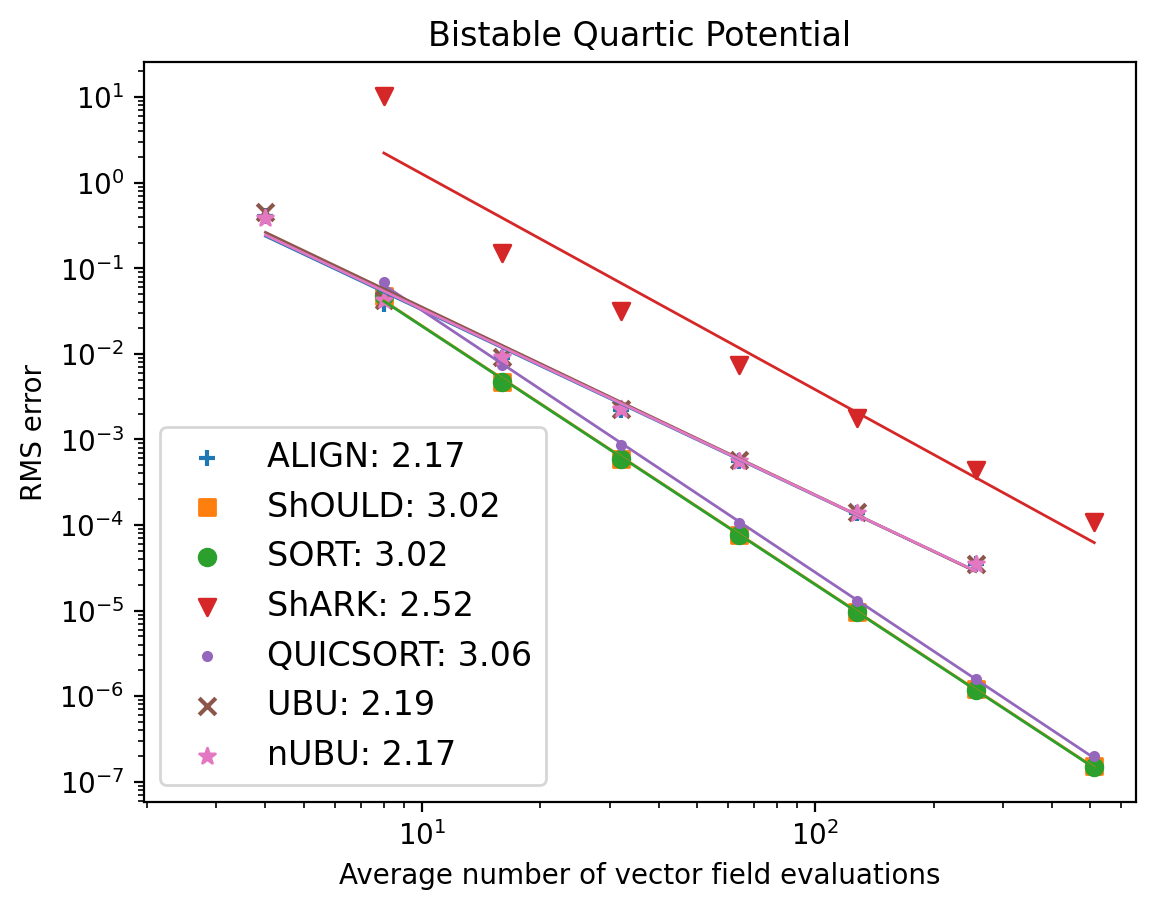

In [9]:
_ = draw_order_multiple(
    [
        out_ALIGN_bqp,
        out_ShOULD_bqp,
        out_SORT_bqp,
        out_ShARK_bqp,
        out_QUICSORT_bqp,
        out_UBU_bqp,
        out_nUBU_bqp,
    ],
    ["ALIGN", "ShOULD", "SORT", "ShARK", "QUICSORT", "UBU", "nUBU"],
    title="Bistable Quartic Potential",
)

## The "ULD3" Oscillator
Three particles in a 3D potential with three minima at (2, 2, 2), (-2, -2, -2) and (3, -1, 0).

In [17]:
uld3_long = get_uld3_langevin(t0, t_long, dtype=dtype)
terms_uld3_long = uld3_long.get_terms(
    uld3_long.get_bm(key, levy_area=levy_area, tol=2**-10)
)
uld3 = get_uld3_langevin(t0, t1, dtype=dtype)
uld3_short = get_uld3_langevin(t0, t_short, dtype=dtype)

solALIGN_uld3 = diffeqsolve(
    terms_uld3_long,
    ALIGN(0.1),
    t0,
    t_long,
    dt0=dt0,
    y0=uld3_long.y0,
    args=uld3_long.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_langevin(solALIGN_uld3)
plot_sol3D(solALIGN_uld3)

In [17]:
# ref_sol_uld3 = get_fine_solutions(keys, uld3_short, ShARK(), levy_area, bm_tol, 6, 16)
# jnp.save("data/ref_sol_uld3.npy", ref_sol_uld3)
ref_sol_uld3 = load_ref_sol_langevin("uld3")
print(jtu.tree_map(lambda x: x.shape, ref_sol_uld3))

In [18]:
# out_ALIGN_uld3 = constant_step_strong_order(keys, uld3_short, ALIGN(0.1), (2,8), bm_tol, levy_area, ref_sol_uld3)
# save_order_results(out_ALIGN_uld3, "uld3_ALIGN_const")
out_ALIGN_uld3 = load_order_results("uld3_ALIGN_const")

# out_ShOULD_uld3 = constant_step_strong_order(
#     keys, uld3_short, ShOULD(0.01), (2,8), bm_tol, levy_area, ref_sol_uld3
# )
# save_order_results(out_ShOULD_uld3, "uld3_ShOULD_const")
out_ShOULD_uld3 = load_order_results("uld3_ShOULD_const")

# out_SORT_uld3 = constant_step_strong_order(keys, uld3_short, SORT(0.01), (2,8), bm_tol, levy_area, ref_sol_uld3)
# save_order_results(out_SORT_uld3, "uld3_SORT_const")
out_SORT_uld3 = load_order_results("uld3_SORT_const")

# out_ShARK_uld3 = constant_step_strong_order(keys, uld3_short, ShARK(), (2,8), bm_tol, levy_area, ref_sol_uld3)
# save_order_results(out_ShARK_uld3, "uld3_ShARK_const")
out_ShARK_uld3 = load_order_results("uld3_ShARK_const")

# out_QUICSORT_uld3 = constant_step_strong_order(keys, uld3_short, QUICSORT(0.01), (2,8), bm_tol, levy_area, ref_sol_uld3)
# save_order_results(out_QUICSORT_uld3, "uld3_QUICSORT_const")
out_QUICSORT_uld3 = load_order_results("uld3_QUICSORT_const")

In [19]:
_ = draw_order_multiple(
    [out_ALIGN_uld3, out_ShOULD_uld3, out_SORT_uld3, out_ShARK_uld3, out_QUICSORT_uld3],
    ["ALIGN", "ShOULD", "SORT", "ShARK", "QUICSORT"],
    title="ULD3",
)